# Project Description

The model created in this notebook is a chatbot called **Cardio-Guardian Bot** that help users understand the various Cardio Vascular Diseases(CVD) and their symptoms, causes, prevention and treatment.


This model is built to be a learning tool.

#### Author

- Nino Chibuzor Nwachukwu

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import json
import pickle
import torch
import random
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Tokenizer and BERT model initialized

In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Data Reading and Preprocessing

The dataset(questions and answers) was retrieved from [WHO report](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)?gad_source=1&gclid=CjwKCAjwyo60BhBiEiwAHmVLJac3oS13DOiZUy0wLJ5n4Z-mYHvjhVOOvjwUYeG0WRd0OYzQPw3abxoCLUcQAvD_BwE) and another [WHO](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_2) report and [Heart Disease Facts site](https://www.cdc.gov/heart-disease/data-research/facts-stats/index.html)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/cvd_data.csv")
df.head()

,Questions,Answers,Patterns,Tags
0,What are cardiovascular diseases (CVDs)?,Cardiovascular diseases (CVDs) are a group of ...,What is meant by CVDs? Define cardiovascular d...,cvd_definition
1,What causes heart attacks?,Heart attacks are mainly caused by a blockage ...,What leads to a heart attack? Reasons for hear...,heart_attack_cause
2,What are the risk factors for cardiovascular d...,The most important risk factors are unhealthy ...,What increases the risk of CVDs? Factors contr...,cvd_risk_factors
3,How can cardiovascular diseases be prevented?,CVDs can be prevented by addressing risk facto...,Ways to prevent heart diseases? How to avoid C...,cvd_prevention
4,What is coronary heart disease?,It is a disease of the blood vessels supplying...,Explain coronary heart disease What is CHD?,coronary_heart_disease


In [ ]:
df.dropna(inplace=True)
df.head()

,Questions,Answers,Patterns,Tags
0,What are cardiovascular diseases (CVDs)?,Cardiovascular diseases (CVDs) are a group of ...,What is meant by CVDs? Define cardiovascular d...,cvd_definition
1,What causes heart attacks?,Heart attacks are mainly caused by a blockage ...,What leads to a heart attack? Reasons for hear...,heart_attack_cause
2,What are the risk factors for cardiovascular d...,The most important risk factors are unhealthy ...,What increases the risk of CVDs? Factors contr...,cvd_risk_factors
3,How can cardiovascular diseases be prevented?,CVDs can be prevented by addressing risk facto...,Ways to prevent heart diseases? How to avoid C...,cvd_prevention
4,What is coronary heart disease?,It is a disease of the blood vessels supplying...,Explain coronary heart disease What is CHD?,coronary_heart_disease


## Intents



In [ ]:
dict_ = {"intents":[]}

# dict_
questions = None
for ind in df.index:
    ques = df['Questions'][ind].lower()
    patterns = df['Patterns'][ind].lower().split('?')
    patterns = [p.strip() for p in patterns if p.strip()]
    patterns.append(ques.strip())
    ans = df['Answers'][ind]
    dict1 = {'tags': df['Tags'][ind]}
    dict1['patterns'] = patterns
    dict1['responses'] = [ans]  # Store responses as a list
    dict_['intents'].append(dict1)

    # ques = ques.replace('?','.')
    # ques += df['Patterns'][ind].lower()
    # ques = ques.split('.')
    # for i, q in enumerate(ques):
    #     ques[i] = q.strip()
    # ans = df['Answers'][ind]
    # dict1 = {'tags': df['Tags'][ind]}
    # dict1['patterns'] = ques[:-1]
    # dict1['responses'] = ans
    # dict_['intents'].append(dict1)

# print(dict_)
print(dict_["intents"][:2])

with open("cvd_intents.json", "w") as f:
    f.write(json.dumps(dict_))

[{'tags': 'cvd_definition', 'patterns': ['what is meant by cvds', 'define cardiovascular diseases.', 'what are cardiovascular diseases (cvds)?'], 'responses': ['Cardiovascular diseases (CVDs) are a group of disorders of the heart and blood vessels.']}, {'tags': 'heart_attack_cause', 'patterns': ['what leads to a heart attack', 'reasons for heart attacks', 'what causes heart attacks?'], 'responses': ['Heart attacks are mainly caused by a blockage that prevents blood from flowing to the heart.']}]


## Creating bag of words

In [ ]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):  # Ensure pattern is a string
            pattern = pattern.strip()  # Remove leading/trailing whitespace
            word_list = word_tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags']))
            if intent['tags'] not in classes:
                classes.append(intent['tags'])
# print(documents)

lemmatizer=WordNetLemmatizer()

words =[lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes=sorted(set(classes))
pickle.dump(words,open('cvd_words.pkl','wb'))
pickle.dump(classes,open('cvd_classes.pkl','wb'))

## Embeddings

In [ ]:
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]

    # Tokenize and convert to BERT embeddings
    inputs = tokenizer(pattern, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()

    output_row = label_binarizer.transform([tag])[0]

    training.append((embeddings.flatten(), output_row))

# print(training)
# Shuffle and prepare the training data
random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])


## Model Initialization and Training

In [ ]:

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[0]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('cvd_chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50
11/11 [==============================] - 1s 9ms/step - loss: 3.8660 - accuracy: 0.0233 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 3.7077 - accuracy: 0.0465 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 3.6269 - accuracy: 0.1008 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 3.4595 - accuracy: 0.1318 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 3.3723 - accuracy: 0.1938 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 3.2116 - accuracy: 0.1860 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/50
11/11 [==============================] - 0s 8ms/step - loss: 3.0667 - accuracy: 0.2093 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Evaluation

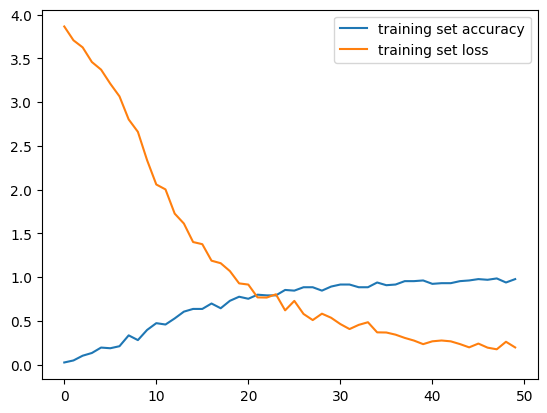

In [ ]:
##plotting model accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],label='training set accuracy')
plt.plot(hist.history['loss'],label='training set loss')
plt.legend()

In [ ]:
# evaluate the model
score = model.evaluate(train_x, train_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04290762543678284
Test accuracy: 1.0


In [ ]:

# Predict the classes for the test set
pred_y = model.predict(np.array(train_x))

# Convert predictions and true labels from one-hot encoding to class labels
pred_y_labels = np.argmax(pred_y, axis=1)
test_y_labels = np.argmax(train_y, axis=1)

# Compute accuracy
accuracy = accuracy_score(test_y_labels, pred_y_labels)
print(f"Accuracy: {accuracy}")

# Compute precision, recall, and F1-score
precision = precision_score(test_y_labels, pred_y_labels, average='weighted')
recall = recall_score(test_y_labels, pred_y_labels, average='weighted')
f1 = f1_score(test_y_labels, pred_y_labels, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



5/5 [==============================] - 0s 3ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Bot Testing

In [ ]:
from tensorflow.keras.models import load_model

with open('cvd_intents.json') as json_file:
    intents = json.load(json_file)

words=pickle.load(open('cvd_words.pkl','rb'))
# print(words[:100], len(words))

classes=pickle.load(open('cvd_classes.pkl','rb'))
# print(classes[:5], len(classes))
model=load_model('cvd_chatbotmodel.h5')
bert_model = BertModel.from_pretrained('bert-base-uncased')


def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings


def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    # print(intents_list[0])
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if tag in i['tags']:
            return i['responses']
    return None

print("GO! BOT IS RUNNING")

while True:
    message=input("")
    if message.lower() in ['quit', 'exit']:
      print("Goodbye")
      break
    ints=predict_class(message)
    if len(ints) > 0:
        res=get_response(ints,intents)
        print(f"Bot: {res}")

GO! BOT IS RUNNING
what is cvd?
1/1 [==============================] - 0s 63ms/step
Bot: ['Cardiovascular diseases (CVDs) are a group of disorders of the heart and blood vessels.']
what causes cvd
1/1 [==============================] - 0s 24ms/step
Bot: ['The most important risk factors are unhealthy diet physical inactivity tobacco use and harmful use of alcohol.']
what causes heart attacks
1/1 [==============================] - 0s 40ms/step
Bot: ['Heart attacks are mainly caused by a blockage that prevents blood from flowing to the heart.']
how to avoid cvd
1/1 [==============================] - 0s 21ms/step
Bot: ['CVDs can be prevented by addressing risk factors such as diet exercise and avoiding tobacco and alcohol.']
stroke symptoms
1/1 [==============================] - 0s 21ms/step
Bot: ['Symptoms include sudden weakness confusion trouble seeing and severe headache.']
exit
Goodbye
